In [1]:
import urllib2
import numpy as np
from math import log10,factorial
from numpy.linalg import det,inv
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
import random
from nltk.tokenize import word_tokenize
import nltk
import re
from nltk.corpus import stopwords
import random
import pickle
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def indicator(y,cls):
    if y==cls:
        return 1
    else:
        return 0


In [3]:
def num_cls(Y,cls):
    sum1 = 0
    for i in Y:
        
        sum1 += indicator(i,cls)
    return sum1


In [4]:
def cal_mu(X,Y,cls):
    sum1 = 0
    for i in range(len(X)):
        sum1 += indicator(Y[i],cls)*X[i]
    mu = sum1/num_cls(Y,cls)
    return np.reshape(mu,(len(mu),1))

#cal_mu(X,Y,0)

In [5]:
def cal_sigma(X,Y,cls):
    sigma = []
    sum1 = 0
    mu = cal_mu(X,Y,cls)
    for i in range(len(X)):
        x = np.reshape(X[i],(len(X[i]),1))
        sum1 += indicator(Y[i],cls)*(np.dot((x - mu),np.transpose(x-mu)))
    return sum1/num_cls(Y,cls)
        
#cal_sigma(X,Y,0)

In [6]:
def cal_alpha(X,Y,cls):
    return (1.*num_cls(Y,cls)/len(Y))
#cal_alpha(X,Y,0)

In [7]:
def training(X,Y,cat):
    mu = []
    sigma = []
    alpha = []
    for cls in cat:
        mu.append(cal_mu(X,Y,cls))
        sigma.append(cal_sigma(X,Y,cls))
        alpha.append(cal_alpha(X,Y,cls))
    return mu,sigma,alpha
#training(X,Y,cat)

In [8]:

def membership(X,mu,sigma,alpha,cls):
    
    
    x = np.reshape(X,(len(X),1))
    mu = mu[cls]
    sigma = sigma[cls]
    alpha = alpha[cls]
    return ((-log10(det(sigma))) - (0.5*np.dot(np.dot(np.transpose(x-mu),inv(sigma)),(x-mu))) + log10(alpha))    


In [9]:
def discriminant(mem_class0,mem_class1,thres):
    if (mem_class0-mem_class1)>thres:
        return 0
    else:
        return 1

In [10]:
def accuracy(Y,Y_hat):
    sum1 = 0
    for i in range(len(Y)):
        #print Y[i]
        #print Y_hat[i]
        if Y[i] != Y_hat[i]:
            sum1 += 1
    return 1.0*sum1/len(Y)
#accuracy([1,1,1,0,0,0],[1,1,1,0,0,1])

In [11]:
def ten_cross_fold(X,Y,cat):
    
    #print thres
    
    accuracies = []
    cv = KFold(len(Y),10)
    for train_id,test_id in cv:
        Y_hat = []
        mu,sigma,alpha = training(X[train_id],Y[train_id],cat)
        
        
        
        for x in X[test_id]:
            
            
            g = []
            for cls in cat:
                g.append(membership(x,mu,sigma,alpha,cls)[0][0])
            
            Y_hat.append(g.index(max(g)))
        
        accuracies.append(accuracy(Y[test_id],Y_hat))
    return np.mean(accuracies)
            
        
     

In [12]:
def measures(X,Y,cat):
    
    
    
    a = len(Y)/5

    Y_pred = []
    mu,sigma,alpha = training(X[:len(Y)-a],Y[:len(Y)-a],cat)
    
    for x in X[len(Y)-a:]:
        g = []
        for cls in cat:
            g.append(membership(x,mu,sigma,alpha,cls)[0][0])
        Y_pred.append(g.index(max(g)))
        
    Y_true = Y[len(Y)-a:]
    
    
    confusion_matrix = []
    for cls_pred in cat:
        c = []
        for cls_true in cat:
            sum1 = 0
            for i,j in zip(Y_pred,Y_true):                
                if i == cls_pred:
                    if j == cls_true:
                        sum1 += 1
            c.append(sum1)
        confusion_matrix.append(c)

    confusion_matrix = np.array(confusion_matrix)
    #print type(confusion_matrix)
    print confusion_matrix
    print "\n"
    
    sum_diagonals = 0
    sum_all = 0
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            sum_all += confusion_matrix[i,j]
            if i==j:
                sum_diagonals += confusion_matrix[i,j]
    print "ACCURACY: ",(1.*sum_diagonals/sum_all)
    print "\n"
    
    
    for cls in cat:
        sum_row = 0
        sum_col = 0
        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                
                if i==cls:
                    sum_row += confusion_matrix[i,j]
                if j==cls:
                    sum_col += confusion_matrix[i,j]
        precision = 1.*confusion_matrix[cls,cls]/sum_row
        
        recall = 1.*confusion_matrix[cls,cls]/sum_col
        
        print "precision for class %d is %f" % (cls,precision)
        print "Recall for class %d is %f" % (cls,recall)
        print "F measure for class %d is %f" % (cls,(2. *precision*recall)/(precision+recall))
        print "\n"
        
    
#measures(X,Y,set([0,1]))

In [41]:
def ROC_curve(X,Y,cat,thres):
    
    a = len(Y)/5

    Y_pred = []
    mu,sigma,alpha = training(X[:len(Y)-a],Y[:len(Y)-a],cat)
    
    for x in X[len(Y)-a:]:
        g = []
        for cls in cat:
            g.append(membership(x,mu,sigma,alpha,cls)[0][0])
        #print g
        Y_pred.append(discriminant(g[0],g[1],thres))
        
    Y_true = Y[len(Y)-a:]
    
    
    confusion_matrix = []
    for cls_pred in cat:
        c = []
        for cls_true in cat:
            sum1 = 0
            for i,j in zip(Y_pred,Y_true):                
                if i == cls_pred:
                    if j == cls_true:
                        sum1 += 1
            c.append(sum1)
        confusion_matrix.append(c)

    confusion_matrix = np.array(confusion_matrix)
    
    
    
    precision_all =[]
    recall_all = []
    
    
    for cls in cat:
        sum_row = 0
        sum_col = 0
        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                
                if i==cls:
                    sum_row += confusion_matrix[i,j]
                if j==cls:
                    sum_col += confusion_matrix[i,j]
        if sum_row == 0:
            precision = 0
        else:
            precision = 1.*confusion_matrix[cls,cls]/sum_row
        precision_all.append(precision)
        
        if sum_col == 0:
            recall = 0
        else:
            recall = 1.*confusion_matrix[cls,cls]/sum_col
        recall_all.append(recall)
        
    
    return precision_all,recall_all
    

In [14]:
## 1 dimension 2 class data set for GDA

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
data = urllib2.urlopen(url)
data = data.read()
data = data.split("\r\n")
random.shuffle(data)

X = []
Y = []
for i in data:
    i = i.split(',')
    Y.append(int(i[len(i)-1]))
    i = map(float,i[0:len(i)-1])
    X.append(i[0])
X = np.reshape(np.array(X),(len(X),1))
cat = (set(Y))
Y = np.reshape(np.array(Y),(len(Y),1))
#print X.shape
#print Y.shape
print cat

error = ten_cross_fold(X,Y,cat)
print "Error by 10 cross fold: ",error

measures(X,Y,cat)




set([0, 1])
Error by 10 cross fold:  0.155199407595
[[130  14]
 [ 20 110]]


ACCURACY:  0.875912408759


precision for class 0 is 0.902778
Recall for class 0 is 0.866667
F measure for class 0 is 0.884354


precision for class 1 is 0.846154
Recall for class 1 is 0.887097
F measure for class 1 is 0.866142




In [37]:
## n dimension 2 class data for GDA
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
data = urllib2.urlopen(url)
data = data.read()
data = data.split("\r\n")
random.shuffle(data)




Error by 10 cross fold:  0.0152967311964
[[142   0]
 [  4 128]]


ACCURACY:  0.985401459854


precision for class 0 is 1.000000
Recall for class 0 is 0.972603
F measure for class 0 is 0.986111


precision for class 1 is 0.969697
Recall for class 1 is 1.000000
F measure for class 1 is 0.984615




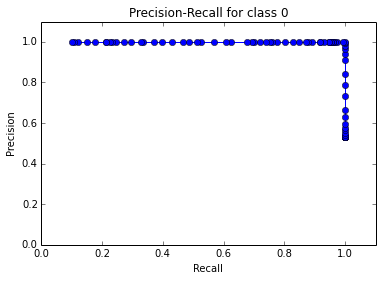

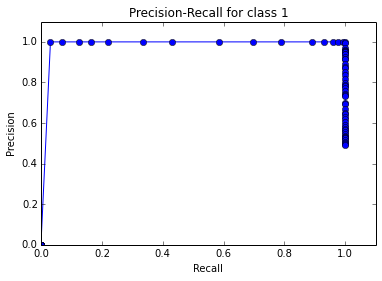

In [44]:
X = []
Y = []
for i in data:
    i = i.split(',')
    Y.append(int(i[len(i)-1]))
    i = map(float,i[0:len(i)-1])
    X.append(i)
    
X = np.array(X)
cat = (set(Y))
Y = np.reshape(np.array(Y),(len(Y),1))

#print X.shape
#print Y.shape
#print np.sum(Y)
error = ten_cross_fold(X,Y,cat)

print "Error by 10 cross fold: ",error

measures(X,Y,cat)

##plotting the curve for precision and recall for different threshold values####

thres = np.arange(-50,50,1)
#print len(thres)


precision_0 = []
precision_1 = []
recall_0 = []
recall_1 = []

for th in thres:
    
    precision_all,recall_all = ROC_curve(X,Y,cat,th)
    precision_0.append(precision_all[0])
    precision_1.append(precision_all[1])
    recall_0.append(recall_all[0])
    recall_1.append(recall_all[1])

plt.title('Precision-Recall for class 0')
plt.plot(recall_0, precision_0,'-bo')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.1])
plt.xlim([0.0, 1.1])
plt.show()

plt.title('Precision-Recall for class 1')
plt.plot(recall_1, precision_1,'-bo')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.1])
plt.xlim([0.0, 1.1])
plt.show()
#print precision_0
#print recall_0

In [17]:
## n dimension k class data set for GDA

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
data = urllib2.urlopen(url)
data = data.read()
data = data.split("\n")
data = data[0:len(data)-2]
random.shuffle(data)

X = []
Y = []
for i in data:
    i = i.split(',')
    Y.append(i[len(i)-1])
    i = map(float,i[0:len(i)-1])
    X.append(i)
for i in range(len(Y)):
    if Y[i] == 'Iris-setosa':
        Y[i] = 0
    elif Y[i] == 'Iris-versicolor':
        Y[i] = 1
    elif Y[i] == 'Iris-virginica':
        Y[i] = 2
X = np.array(X)
cat = (set(Y))
Y = np.reshape(np.array(Y),(len(Y),1))
#print len(Y)   
error = ten_cross_fold(X,Y,cat)
print "Error by 10 cross fold: ",error
measures(X,Y,cat)

Error by 10 cross fold:  0.02
[[ 7  0  0]
 [ 0 10  0]
 [ 0  2 11]]


ACCURACY:  0.933333333333


precision for class 0 is 1.000000
Recall for class 0 is 1.000000
F measure for class 0 is 1.000000


precision for class 1 is 1.000000
Recall for class 1 is 0.833333
F measure for class 1 is 0.909091


precision for class 2 is 0.846154
Recall for class 2 is 1.000000
F measure for class 2 is 0.916667




In [18]:
############################# Naive Bayes Bernoulli's############################################

In [19]:
def prior_bernoulli(Y,cls):
    
    sum1 = 0
    for i in Y:
        sum1 += indicator(i,cls)
    prior = 1.*sum1/len(Y)
    
    return prior

#prior_bernoulli(Y,0)

In [20]:
def alpha_bernoulli(X,Y,cls):

    e = 0.001
    alpha = []
    sum_num = 0
    sum_den = 0
    for i in range(X.shape[1]):
        for j in range(X.shape[0]):
            sum_num += indicator(Y[j],cls)*X[j][i]
            sum_den += indicator(Y[j],cls)
        alpha.append((1.*sum_num + e)/(sum_den + 2*e))

    return alpha
        

#alpha_bernoulli(X[0:10],Y[0:10],0)

In [21]:
def membership_bernoulli(X,alpha,prior,cls):
    
    g = 0
   
    for i in range(len(X)):
        g += (X[i]*log10(alpha[cls][i])) + ((1-X[i])*log10(1-alpha[cls][i]))
         
    g += log10(prior[cls])
    

    return g
    


In [22]:
def training_bernoulli(X,Y,cat):
    prior = []
    alpha = []
    for cls in cat:
        prior.append(prior_bernoulli(Y,cls))
        alpha.append(alpha_bernoulli(X,Y,cls))
    return prior,alpha


#training_bernouli(X[0:10],Y[0:10],cat)

In [23]:
def ten_cross_fold_bernoulli(X,Y,cat):
    
    accuracies = []
    cv = KFold(len(Y),10)
    for train_id,test_id in cv:
        Y_hat = []
        prior,alpha = training_bernoulli(X[train_id],Y[train_id],cat)
        
        for x in X[test_id]:
            
            g = []
            
            for cls in cat:
                g.append(membership_bernoulli(x,alpha,prior,cls))
            Y_hat.append(g.index(max(g)))
        
        accuracies.append(accuracy(Y[test_id],Y_hat))
    return np.mean(accuracies)


In [24]:
def measures_bernoulli(X,Y,cat):
    
    
    
    a = len(Y)/5

    Y_pred = []
    prior,alpha = training_bernoulli(X[:len(Y)-a],Y[:len(Y)-a],cat)
    
    for x in X[len(Y)-a:]:
        g = []
        for cls in cat:
            g.append(membership_bernoulli(x,alpha,prior,cls))
        Y_pred.append(g.index(max(g)))
        
    Y_true = Y[len(Y)-a:]
    
    
    confusion_matrix = []
    for cls_pred in cat:
        c = []
        for cls_true in cat:
            sum1 = 0
            for i,j in zip(Y_pred,Y_true):                
                if i == cls_pred:
                    if j == cls_true:
                        sum1 += 1
            c.append(sum1)
        confusion_matrix.append(c)

    confusion_matrix = np.array(confusion_matrix)
    #print type(confusion_matrix)
    print confusion_matrix
    print "\n"
    
    sum_diagonals = 0
    sum_all = 0
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            sum_all += confusion_matrix[i,j]
            if i==j:
                sum_diagonals += confusion_matrix[i,j]
    print "ACCURACY: ",(1.*sum_diagonals/sum_all)
    print "\n"
    for cls in cat:
        sum_row = 0
        sum_col = 0
        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                
                if i==cls:
                    sum_row += confusion_matrix[i,j]
                if j==cls:
                    sum_col += confusion_matrix[i,j]
        precision = 1.*confusion_matrix[cls,cls]/sum_row
        recall = 1.*confusion_matrix[cls,cls]/sum_col
        print "precision for class %d is %f" % (cls,precision)
        print "Recall for class %d is %f" % (cls,recall)
        print "F measure for class %d is %f" % (cls,(2. *precision*recall)/(precision+recall))
        print "\n"

In [25]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
data = urllib2.urlopen(url)
data = data.read()
data = data.split("\r\n")
data = data[:len(data)-1]
random.shuffle(data)
x = []
Y = []
for i in data:
    i = i.split(',')
    x.append(map(float,i[:48]))
    Y.append(map(int,i[57])[0])
    

X = []
for i in x:
    a = []
    for j in i:
        if j == 0:
            a.append(0)
        else:
            a.append(1)
    X.append(a)



X = np.array(X)
cat = set(Y)

Y = np.reshape(np.array(Y),(len(Y),1))


error = ten_cross_fold_bernoulli(X,Y,cat)
print "Error by 10 cross fold: ",error

measures_bernoulli(X,Y,cat)


Error by 10 cross fold:  0.299717061209
[[455 175]
 [ 95 195]]


ACCURACY:  0.70652173913


precision for class 0 is 0.722222
Recall for class 0 is 0.827273
F measure for class 0 is 0.771186


precision for class 1 is 0.672414
Recall for class 1 is 0.527027
F measure for class 1 is 0.590909




In [26]:
################################ Naive Bayes Binomial's################################################################

In [27]:
def f(n):
    return factorial(n)
f(1)

1

In [28]:
def prior_binomial(Y,cls):
    
    sum1 = 0
    for i in Y:
        sum1 += indicator(i,cls)
    prior = 1.*sum1/len(Y)
    
    return prior
prior_binomial(Y,0)

0.6059552271245382

In [29]:
def alpha_binomial(X,Y,cls):

    e = 0.001
    alpha = []
    sum_num = 0
    sum_den = 0
    for i in range(X.shape[1]):
        for j in range(X.shape[0]):
            sum_num += indicator(Y[j],cls)*X[j][i]
            sum_den += indicator(Y[j],cls)*P[j][0]
        alpha.append((1.*sum_num + e)/(sum_den + 2*e))

    return alpha
#print alpha_binomial(X[0:5],Y[0:5],0)
#print alpha_binomial(X[0:5],Y[0:5],1)

In [30]:
def membership_binomial(X,alpha,prior,cls):
    
    g = 0
    P = sum(X)
    for i in range(len(X)):
        g +=   log10(f(P)/(f(X[i])*f(P-X[i]))) + (X[i]*log10(alpha[cls][i])) + ((P-X[i])*log10(1-alpha[cls][i]))
         
    g += log10(prior[cls])
    

    return g

In [31]:
def training_binomial(X,Y,cat):
    prior = []
    alpha = []
    for cls in cat:
        prior.append(prior_binomial(Y,cls))
        alpha.append(alpha_binomial(X,Y,cls))
    return prior,alpha
#training_binomial(X[0:10],Y[0:10],cat)

In [32]:
def ten_cross_fold_binomial(X,Y,cat):
    
    accuracies = []
    cv = KFold(len(Y),10)
    for train_id,test_id in cv:
        Y_hat = []
        prior,alpha = training_binomial(X[train_id],Y[train_id],cat)
        
        for x in X[test_id]:
            
            g = []
            
            for cls in cat:
                g.append(membership_binomial(x,alpha,prior,cls))
            Y_hat.append(g.index(max(g)))
        
        accuracies.append(accuracy(Y[test_id],Y_hat))
    return np.mean(accuracies)


In [33]:
def measures_binomial(X,Y,cat):
    
    
    
    a = len(Y)/5

    Y_pred = []
    prior,alpha = training_binomial(X[:len(Y)-a],Y[:len(Y)-a],cat)
    
    for x in X[len(Y)-a:]:
        g = []
        for cls in cat:
            g.append(membership_binomial(x,alpha,prior,cls))
        Y_pred.append(g.index(max(g)))
        
    Y_true = Y[len(Y)-a:]
    
    
    confusion_matrix = []
    for cls_pred in cat:
        c = []
        for cls_true in cat:
            sum1 = 0
            for i,j in zip(Y_pred,Y_true):                
                if i == cls_pred:
                    if j == cls_true:
                        sum1 += 1
            c.append(sum1)
        confusion_matrix.append(c)

    confusion_matrix = np.array(confusion_matrix)
    #print type(confusion_matrix)
    print confusion_matrix
    print "\n"
    
    sum_diagonals = 0
    sum_all = 0
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            sum_all += confusion_matrix[i,j]
            if i==j:
                sum_diagonals += confusion_matrix[i,j]
    print "ACCURACY: ",(1.*sum_diagonals/sum_all)
    print "\n"
    for cls in cat:
        sum_row = 0
        sum_col = 0
        for i in range(confusion_matrix.shape[0]):
            for j in range(confusion_matrix.shape[1]):
                
                if i==cls:
                    sum_row += confusion_matrix[i,j]
                if j==cls:
                    sum_col += confusion_matrix[i,j]
        precision = 1.*confusion_matrix[cls,cls]/sum_row
        recall = 1.*confusion_matrix[cls,cls]/sum_col
        print "precision for class %d is %f" % (cls,precision)
        print "Recall for class %d is %f" % (cls,recall)
        print "F measure for class %d is %f" % (cls,(2. *precision*recall)/(precision+recall))
        print "\n"

In [34]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
data = urllib2.urlopen(url)
data = data.read()
data = data.split("\r\n")
data = data[:len(data)-1]
random.shuffle(data)
x = []
Y = []
for i in data:
    i = i.split(',')
    x.append(map(float,i[:48]))
    Y.append(map(int,i[57])[0])
    

X = []
for i in x:
    a = []
    for j in i:
        if j == 0:
            a.append(0)
        else:
            a.append(int(math.ceil(1.*j*10)))
    X.append(a)



X = np.array(X)
cat = set(Y)

Y = np.reshape(np.array(Y),(len(Y),1))


P = []
for i in range(len(X)):
    P.append(sum(X[i]))
P = np.reshape(np.array(P),(len(P),1))

error = ten_cross_fold_binomial(X,Y,cat)
print "Error by 10 cross fold: ",error

measures_binomial(X,Y,cat)


Error by 10 cross fold:  0.303851268509
[[266  14]
 [299 341]]


ACCURACY:  0.659782608696


precision for class 0 is 0.950000
Recall for class 0 is 0.470796
F measure for class 0 is 0.629586


precision for class 1 is 0.532813
Recall for class 1 is 0.960563
F measure for class 1 is 0.685427


